### <span style="color:red">IMPORTANT: Only modify cells which have the following comment:</span>
```python
# Modify this cell
```
##### <span style="color:red">Do not add any new cells when you submit the homework. Only use the already provided python packages.</span>

## Analysis of stock prices using PCA / Notebook 1

In this take-home final you are to analyze the daily changes in stock prices using PCA and to mesure the dimension of stock sequences.

We Start by downloading data and pre-processing it to make it ready for analysis using Spark.

In [1]:
import sys,os
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
import math
import pandas as pd
from glob import glob
import pickle


### Stock Info
The Pickle file `Tickers.pkl` contains information about the stocks in the SP500.

* `TickerInfo` - a pandas table that stores the name, sector, and sector ID for 505 stocks
* `Tickers` - A list of the stocks that we are going to analyze (each student should eliminate a few of these stocks before doing their analysis)


In [2]:
D=pickle.load(open('Tickers.pkl','rb'))
TickerInfo=D['TickerInfo']
Tickers=D['Tickers']
Sectors={'Consumer Discretionary':'CD',
 'Consumer Staples':'CS',
 'Energy':'EN',
 'Financials':'FIN',
 'Health Care':'HC',
 'Industrials':'INDS',
 'Information Technology':'IT',
 'Materials':'MAT',
 'Real Estate':'RE',
 'Telecommunication Services':'TS',
 'Utilities':'UTIL'}

In [3]:
TickerInfo.head()

,Ticker,Name,Sector,SECTOR_ID
0,MMM,3M|3M Company,Industrials,INDS
1,ABT,Abbott Laboratories,Health Care,HC
2,ABBV,AbbVie Inc.,Health Care,HC
3,ACN,Accenture plc,Information Technology,IT
4,ATVI,Activision Blizzard,Information Technology,IT


### Differences between the stocks lists
In the following you will work with three different sets of stocks:

1. The stocks listed in `TickerInfo`
2. The stocks listed in `Tickers`
3. The stock files that you will download from S3.

* The stocks you will analyze are those in `Tickers` less the one that you were instructed to remove.
* The Files you will download contain all of the stocks in `Tickers` plus a few stocks that are skipped because they are outliers.
* The Stocks in `TickerInfo` include most of the stocks in `Tickers`, but there are a few missing. When we will represent each stock with its `SECTOR_ID` these stocks will be represented by their Ticker.

In [4]:
len(Tickers),len(TickerInfo)

(481, 505)

### Stock and sector information
`TickerInfo` is a pandas table containing, for each Ticker, the company name, the sector, and a sector ID. There are 11 sectors. Some, such as `Consumer Discretionary` and `Information Technology` include many stocks while others, such as `Telecommunication Services` include very few.

In [5]:
from collections import Counter
L=Counter(TickerInfo['Sector']).items()
print 'Sector ID\t\tSector Name\tNo. of Stocks'
print '=========\t\t===========\t============='
for l in L:
    print '%s\t%30s\t%d'%(Sectors[l[0]],l[0],l[1])

Sector ID		Sector Name	No. of Stocks
=========		===========	=============
INDS	                   Industrials	66
TS	    Telecommunication Services	4
CD	        Consumer Discretionary	84
UTIL	                     Utilities	28
CS	              Consumer Staples	37
HC	                   Health Care	60
MAT	                     Materials	25
IT	        Information Technology	70
RE	                   Real Estate	31
EN	                        Energy	34
FIN	                    Financials	66


### Download Data
The data is a directory with .csv files, one for each stock. This directory has been tarred and uploaded to 
S3, at:

https://mas-dse-open.s3.amazonaws.com/spdata_csv.tgz

**Download and untar** the file. This creates a directory called **spdata_csv**

In [6]:
!curl https://mas-dse-open.s3.amazonaws.com/spdata_csv.tgz | tar -xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   285    0   285    0     0    856      0 --:--:-- --:--:-- --:--:--   863
tar: Unrecognized archive format
tar: Error exit delayed from previous errors.


## Read Data and create a single table

Your task in this notebook is to read the stock-information `.csv` files, extract from them the column 
`Adj. Open` and combine them into a single `.csv` file containing all of the information that is relevant for later analysis.

Below we suggest a particular sequence of steps, you can either follow these steps, or do this in your own way.  The end result should be a file called `SP500.csv` which stores the information described below.

### Convert files into pandas dataframes

In this step you read all of the relevant information into a large dictionary we call `Tables`.

The key to this dictionary is the stocks "ticker" which corresponds to the file name excluding the `.csv` extension.

You should read in all of the files in the directory `spdata_csv` other than:

* Files for tickers that are not in the list `Tickers`.
* Files for tickers that were listed in the email you got for this final.

In the email you got about this final, there is a list of tickers that you should omit from your analysis.

# Task 1:
Create a function **getTables** which returns the dictionary *Tables* as described above. 

######  <span style="color:blue">Code:</span>
```python
Tables = getTables()
print type(Tables)
print len(Tables)
Tables['IBM'].head()
```

######  <span style="color:magenta">Output:</span>
```python
dict
476

```
<p><img alt="" src="figs/IBM.jpg"style="height:180px"  /></p>


In [9]:
def getTables(Data_dir="spdata_csv"):
    #Data_dir: directory path to spdata_csv , default path should be your local path to the file 
    
    Tables={}
    # ... write implementation
    
    omit_list = ['COF','PSA','MO','GD','AVB']
    omit_list = map(lambda x: x+'.csv', omit_list)
    
    for f in glob(Data_dir+"/*.csv"):
        f_name = f.split('/')[1]
        stock_name = f_name[:-4]
        if f_name not in omit_list and stock_name in Tickers:
            stock_df = pd.read_csv(Data_dir+'/'+f_name)
            stock_df.set_index(['Date'], inplace=True)
            Tables[stock_name] = stock_df
        else:
            pass
    
    return Tables   #<-- a dictionary as described above

In [10]:
from Tester import prepare as tasks
Tables = tasks.ex1(getTables)

great job!


### Computing diffs and combining into a single table

The next step is to extract from each table the relevant prices, compute an additional quantity we call `diff` and create a single combined pandas dataframe.

The price we ue is the **Adjusted Open Price** which is the price when the stock exchange opens in the morning. We use the **adjusted** price which eliminates technical adjustments such as stock splits.

It is more meaningful to predict *changes* in prices than prices themselves. We therefor compute for each stock a `Diffs` sequence in which $d(t)=\log \frac{p(t+1)}{p(t)}$ where $p(t)$ is the price at time $t$ and $d(t)$ is the price diff or the price ratio.

Obviously, if we have a price sequence of length $T$ then the length of the diff sequence will be $T-1$. To make the price sequence and the diff sequence have the same length we eliminate the last day price for each sequence.

Your task in this step is to join the stock tables by date, compute the diff seqeunce, and create one large Pandas DataFrame where the row index is the date, and there are two columns for each ticker. For example for the ticker `IBM`, there would be two columns `IBM_P` and `IBM_D`. The first corresponds to the prices of the IBM stock $p(t)$ and the second to the price difference $d(t)$

# Task 2: 

Create a function **computeDiffs**, which creates the dataframe Diffs as specified above


######  <span style="color:blue">Code:</span>
```python
Diffs = computeDiffs(Tables)
print type(Diffs)
print Diffs.shape[1]
print "IBM_D" in Diffs.columns and "IBM_P" in Diffs.columns

```

######  <span style="color:magenta">Output:</span>
```python
<class 'pandas.core.frame.DataFrame'>
952
True
```


In [11]:
def computeDiffs(Tables):
    #Tables: the dictionary Tables that was computed in Task1 
    
    Diffs=pd.DataFrame()
    # ... write implementation
    
    for k in Tables.keys():
        df = Tables[k]
        p_t0 = pd.DataFrame(df.loc[:,'Adj. Open'])
        p_t1 = p_t0.shift(1)
        d = np.log(p_t1.values / p_t0.values)
        p_t1['D'] = d
        df = p_t1.shift(-1)
        df.columns = [k+'_P',k+'_D']
        
        if len(Diffs) == 0:
            Diffs = df
        else:
            Diffs = pd.merge(Diffs, df, how='outer', left_index=True, right_index=True)
        
    return Diffs  #<-- a dataframe as described above



In [12]:
from Tester import prepare as tasks
Diffs = tasks.ex2( computeDiffs(Tables) )

great job!


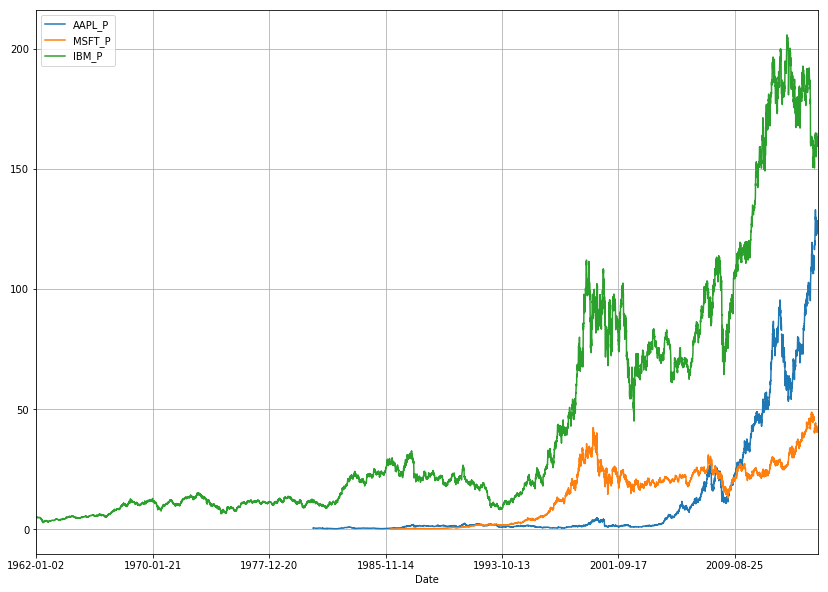

In [13]:
# plot some stocks
Diffs[['AAPL_P','MSFT_P','IBM_P']].plot(figsize=(14,10));
plt.grid()

Lastly,we now save *Diffs* as a csv

In [14]:
Diffs.to_csv('SP500.csv')